# plot_candles: Candlestick Charts for Quantopian

In [1]:
fundamentals = init_fundamentals()

In [2]:
"""Required imports"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
"""This cell defineds the plot_candles function"""

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]})
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x + 0.4, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)

## Basic candlestick chart

In [4]:
# Get some daily pricing to demo.
goog_day_pricing = get_pricing('GOOG', start_date='2016-10-1', end_date='2016-11-21')

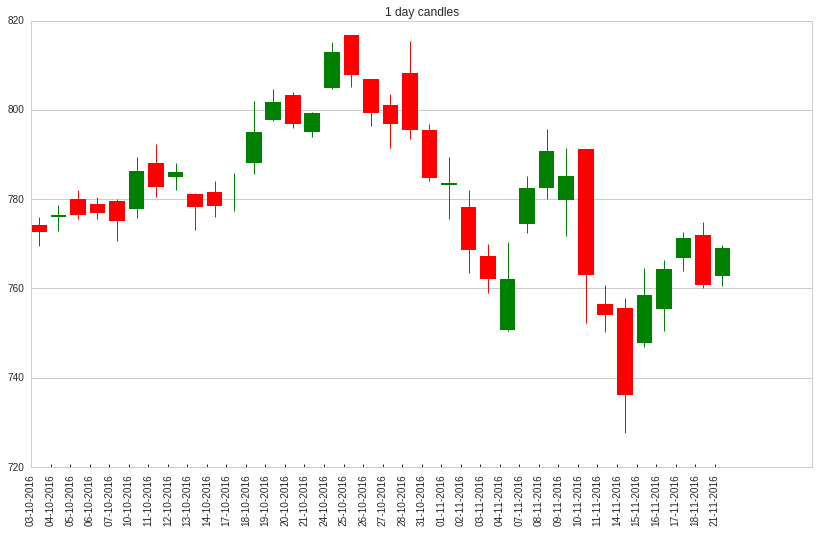

In [5]:
plot_candles(goog_day_pricing, title='1 day candles')

## Candlestick chart with volume bars

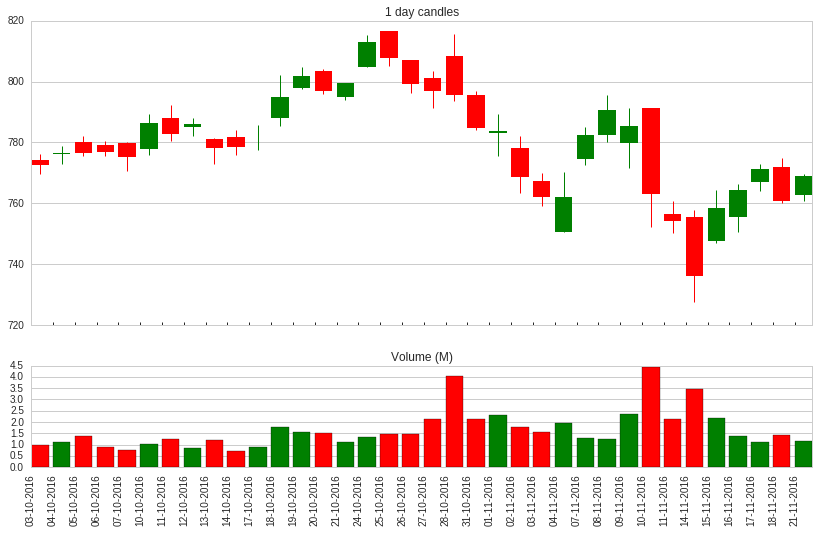

In [6]:
plot_candles(goog_day_pricing, title='1 day candles', volume_bars=True)

## Minute Candles

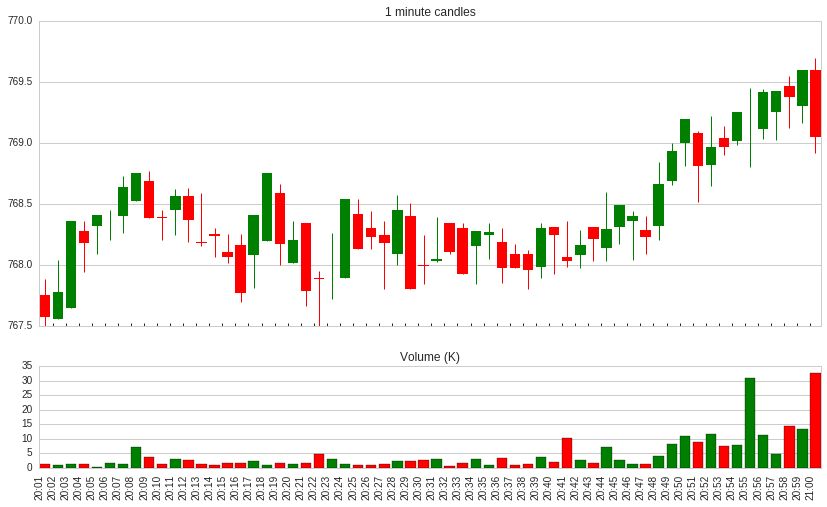

In [7]:
goog_minute_pricing = get_pricing('GOOG', start_date='2016-11-21', end_date='2016-11-21', frequency='minute')
plot_candles(goog_minute_pricing[-60:], title='1 minute candles', volume_bars=True)

## Adding Indicators

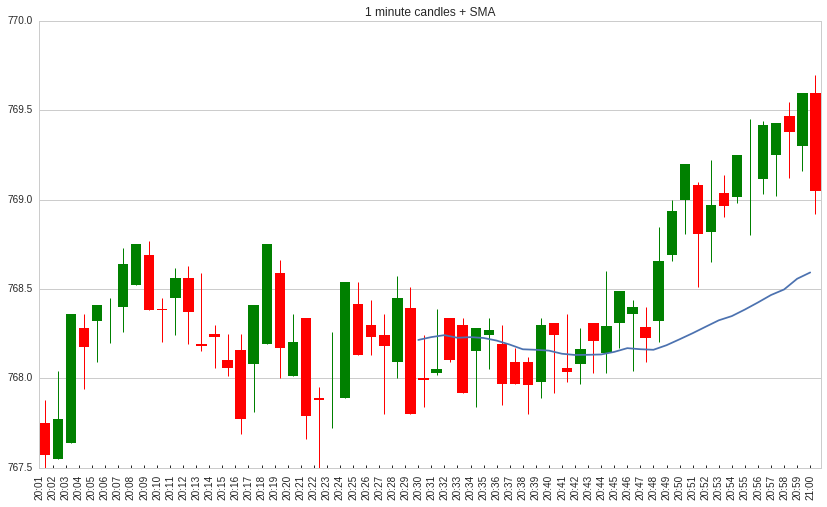

In [16]:
import talib
last_hour = goog_minute_pricing[-60:]

SMA = talib.SMA(last_hour['close_price'].as_matrix())
plot_candles(last_hour,
             title='1 minute candles + SMA',
             technicals=[SMA])

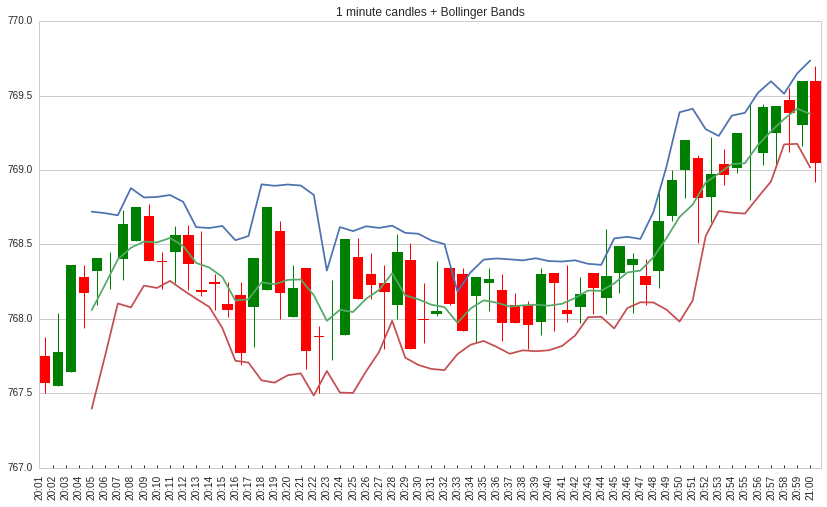

In [18]:
upper, middle, lower = talib.BBANDS(last_hour['close_price'].as_matrix())
plot_candles(last_hour,
             title='1 minute candles + Bollinger Bands',
             technicals=[upper, middle, lower])

## Custom color function: pattern highlighting

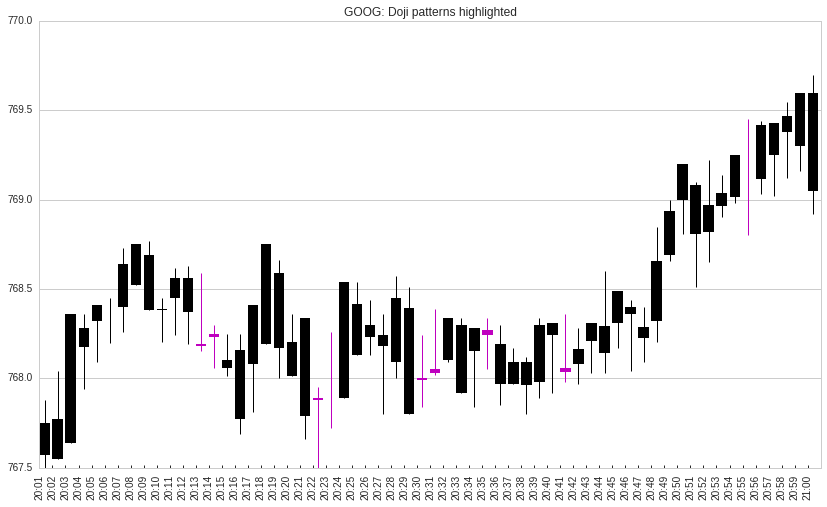

In [20]:
import talib
last_hour = goog_minute_pricing[-60:]

dojis = talib.CDLDOJI(last_hour['open_price'].as_matrix(),
                      last_hour['high'].as_matrix(),
                      last_hour['low'].as_matrix(),
                      last_hour['close_price'].as_matrix())

# Highlight all doji patterns with magenta else black
def highlight_dojis(index, open_price, close_price, low, high):
    return 'm' if dojis[index] else 'k'

plot_candles(last_hour,
             title='Doji patterns highlighted',
             color_function=highlight_dojis)